# Create NQueensSolver class

In [3]:
import numpy as np
import matplotlib.pyplot as plt

class NQueensSolver:
    def __init__(self, *, number_of_objects, sigma, **kwargs):
        assert number_of_objects > 0
        
        self.number_of_objects = number_of_objects 
        self.sigma = sigma
        self.constants = kwargs
        
        self.input_potential_shape = (self.number_of_objects,) * 2
        
    def solution(self):
        return self.output_potential > 0
        
    def output_potential_function(self, input_potential):
        return (input_potential >= 0) * 1
    
    def energy_function(self):
        E = 0
        E_1 = 0
        for i in range(self.number_of_objects):
            for j in range(self.number_of_objects):
                if self.output_potential[i,j] != 0:
                    for k in range(self.number_of_objects):
                        if k != j:
                            E_1 += self.output_potential[i,k] * self.output_potential[i,j]
                        if k != i:
                            E_1 += self.output_potential[k,j] * self.output_potential[i,j]
        E += self.constants["A"] / 2 * E_1
        
        E_2 = 0
        for i in range(self.number_of_objects):
            for j in range(self.number_of_objects):
                if self.output_potential[i,j] != 0:
                    for k in range(self.number_of_objects):
                        if k != i:
                            if i >= 1 and j < i and k >= i - j:
                                E_2 += self.output_potential[k,k - i + j] * self.output_potential[i,j]
                            if j >= i and k < self.number_of_objects + i - j:
                                E_2 += self.output_potential[k,k - i + j] * self.output_potential[i,j]
                            if (j >= self.number_of_objects - i - 1 and k >= i + j - self.number_of_objects + 1):
                                E_2 += self.output_potential[k,i + j - k] * self.output_potential[i,j]
                            if (i < self.number_of_objects - 1 and j < self.number_of_objects - i - 1 and k < i + j + 1):
                                E_2 += self.output_potential[k,i + j - k] * self.output_potential[i,j]
        E += self.constants["B"] / 2 * E_2
        
        E_3 = (self.output_potential.sum() - (self.number_of_objects + self.sigma)) ** 2
        E += self.constants["C"] / 2 * E_3
        
        return E
    
    def train(self, *args, synchronous = True, max_external_iterations = 25, max_external_iterations_with_constant_E = 5, strategy = "A", plot_energy_graph = False):
        assert len(args) == 0 or (len(args[0]) == self.number_of_objects and all([len(args[0][i]) == self.number_of_objects for i in range(self.number_of_objects)]))
        
        internal_iterations, external_iterations, external_iterations_with_constant_E = 0, 0, 0
        
        self.input_potential = np.zeros(self.input_potential_shape)
        self.output_potential = self.output_potential_function(self.input_potential) 
        if strategy == "A":
            self.output_potential = np.zeros(self.input_potential_shape)
        elif strategy == "B":
            self.output_potential = np.random.randint(2, size = self.input_potential_shape)
        elif strategy == "C":
            self.output_potential = np.ones(self.input_potential_shape)
        
        energy_list = [self.energy_function()]
        
        number_of_random_neurons = self.number_of_objects if synchronous is True else 1
        while external_iterations_with_constant_E < max_external_iterations_with_constant_E and external_iterations < max_external_iterations:
            for _ in range(self.number_of_objects ** 2 // number_of_random_neurons):
                random_indexes = np.random.choice(self.number_of_objects ** 2, number_of_random_neurons)
                for index in random_indexes:
                    i, j = index // self.number_of_objects, index % self.number_of_objects

                    self.input_potential[i,j] = - (self.constants["A"] * (self.output_potential[i].sum() - self.output_potential[i,j]) +\
                                                   self.constants["A"] * (self.output_potential[:,j].sum() - self.output_potential[i,j]) +\
                                                   self.constants["C"] * (self.output_potential.sum() - (self.number_of_objects + self.sigma)))
                    
                    if i - j > 0:
                        min_range, max_range = i - j, self.number_of_objects
                    else:
                        min_range, max_range = 0, self.number_of_objects + i - j
                    for k in range(min_range, max_range):
                        if k != i:
                            self.input_potential[i,j] -= self.constants["B"] * self.output_potential[k,k - i + j]
                    if i + j + 2 > self.number_of_objects:
                        min_range, max_range = i + j - self.number_of_objects + 1, self.number_of_objects
                    else:
                        min_range, max_range = 0, i + j + 1
                    for k in range(min_range, max_range):
                        if k != i:
                            self.input_potential[i,j] -= self.constants["B"] * self.output_potential[k,i + j - k]
                
                for index in random_indexes:
                    i, j = index // self.number_of_objects, index % self.number_of_objects
                    self.output_potential[i,j] = self.output_potential_function(self.input_potential[i,j])

            internal_iterations += 1
            if internal_iterations % 5 == 0:
                external_iterations += 1
                energy = self.energy_function()
                if energy == energy_list[-1]:
                    external_iterations_with_constant_E += 1
                else:
                    external_iterations_with_constant_E = 0
                energy_list.append(energy)
            
        if plot_energy_graph is True:
            plt.plot([i for i in range(external_iterations + 1)], energy_list)
            plt.xlabel("Number of External Iterations")
            plt.ylabel("Energy")
            plt.annotate(f"min(E) = {int(energy_list[-1])}", (len(energy_list) - 1 + 0.01, energy_list[-1] + 0.01))
            plt.show()
            
        return energy_list[-1], internal_iterations, external_iterations

# Testing

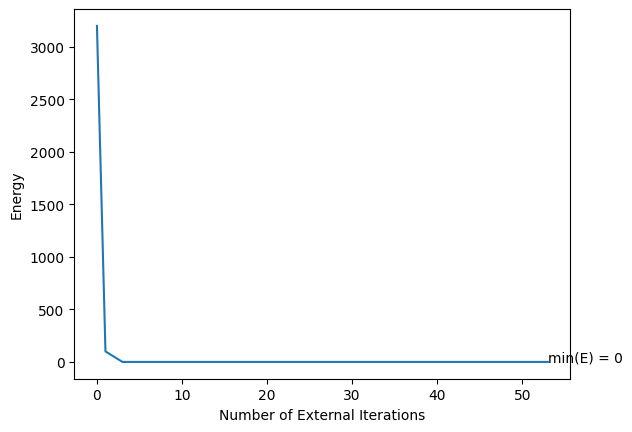

(np.float64(0.0), 265, 53)

In [ ]:
A, B, C, sigma = 100, 100, 100, 0
number_of_queens = 8 
max_external_iterations, max_external_iterations_with_constant_E = 1000, 50 if number_of_queens <= 32 else 100
np.random.seed(42)

hopfield_network = NQueensSolver(number_of_objects = number_of_queens,
                                    sigma = sigma,
                                    A = A,
                                    B = B,
                                    C = C)

hopfield_network.train(synchronous = False,
                       max_external_iterations = max_external_iterations,
                       max_external_iterations_with_constant_E = max_external_iterations_with_constant_E,
                       plot_energy_graph = True)

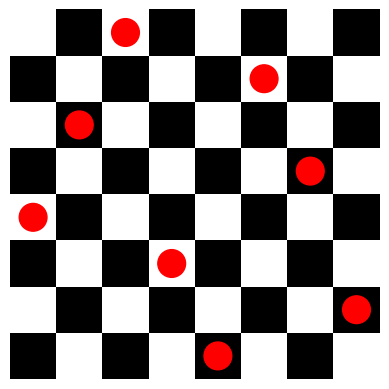

In [12]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
board = hopfield_network.solution()

for i in range(number_of_queens):
    for j in range(number_of_queens):
        color = 'white' if (i + j) % 2 == 0 else 'black'
        rect = plt.Rectangle((j, number_of_queens - 1 - i), 1, 1, facecolor=color)
        ax.add_patch(rect)

for i in range(number_of_queens):
    for j in range(number_of_queens):
        if board[i, j] == 1:
            circle = plt.Circle((j + 0.5, number_of_queens - 1 - i + 0.5), 0.3, color='red')
            ax.add_patch(circle)
ax.set_xlim(0, number_of_queens)
ax.set_ylim(0, number_of_queens)
ax.set_aspect('equal')
ax.axis('off')

plt.show()

In [13]:
# Solution checker for NQP
def check_solution(solution):
    n = len(solution)
    rows, cols, diags, opp_diags = set(), set(), set(), set()

    for i in range(n):
        for j in range(n):
            if solution[i,j] == 1:
                rows.add(i)
                cols.add(j)
                diags.add(i - j)
                opp_diags.add(i + j)

    return len(rows) == len(cols) == len(diags) == len(opp_diags) == n

print("Correct solution:", check_solution(hopfield_network.solution()))

Correct solution: True


# Experimentation

Based on Mandziuk's paper, for n = 4, 8, 16, 32, 48, 64, 80, he found that convergence rate = 100% in all cases except for:
1. 99% for Asynchronous, Strategy A, n = 8
2. 99% for Synchronous, Strategy A, n = 16
3. 99% for Synchronous, Strategy C, n = 16

In [ ]:
import pandas as pd
from tqdm.auto import tqdm
from IPython.display import display_html

strategies = ["A", "B", "C"]
number_of_tests = 100

for number_of_queens in [4, 8, 16, 32, 48, 64, 80]:
    display = ""
    max_external_iterations, max_external_iterations_with_constant_E = 1000, 50 if number_of_queens <= 32 else 100
    
    for synchronous in [False, True]:
        A = B = 100
        if synchronous is True:
            C, sigma = 40, 2
        else:
            C, sigma = 100, 0
        
        hopfield_network = NQueensSolver(number_of_objects = number_of_queens,
                                            sigma = sigma,
                                            A = A,
                                            B = B,
                                            C = C)

        correct_list, iterations_list = [], []
        for strategy in strategies:
            np.random.seed(42)
            iterations_list.append([])
            correct_list.append(0)
            for _ in tqdm(range(number_of_tests), desc = f"{'Synchronous' if synchronous is True else 'Asynchronous'}, Strategy {strategy}, n = {number_of_queens}"):
                energy, internal_iterations, external_iterations = hopfield_network.train(synchronous = synchronous,
                                                                                          max_external_iterations = max_external_iterations,
                                                                                          max_external_iterations_with_constant_E = max_external_iterations_with_constant_E,
                                                                                          strategy = strategy)
                iterations_list[-1].append(external_iterations - max_external_iterations_with_constant_E) # do not count the repeated iterations with minimum E
                correct_list[-1] += check_solution(hopfield_network.solution())
                
        table = pd.DataFrame([[correct_list[i] * 100 // number_of_tests, round(sum(iterations_list[i]) / number_of_tests, 2)] for i in range(len(strategies))], strategies, ["%Succ.", "Iter."])
        display += table.style.set_table_attributes("style = 'display:inline'").set_caption(f"{'Synchronous' if synchronous is True else 'Asynchronous'}, n = {number_of_queens}")._repr_html_()

    display_html(display, raw = True)

Synchronous, Strategy C, n = 4: 100%|██████████| 100/100 [00:09<00:00, 10.14it/s]


,%Succ.,Iter.
A,100,3.290000
B,100,3.110000
C,100,3.040000
,%Succ.,Iter.
A,100,5.230000
B,100,4.390000
C,100,4.320000


Synchronous, Strategy C, n = 8: 100%|██████████| 100/100 [00:34<00:00,  2.90it/s]


,%Succ.,Iter.
A,100,10.700000
B,100,10.530000
C,100,9.280000
,%Succ.,Iter.
A,100,11.950000
B,99,10.300000
C,100,11.510000
